In [1]:
!pip install minio


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install numpy pandas matplotlib tensorflow scikit-learn onnx tf2onnx torch torchvision transformers accelerate python-dotenv flask flask_cors onnxruntime imbalanced-learn datasets peft bitsandbytes jupyter nbconvert lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 266.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 184.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 297.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 203.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 260.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 359.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 219.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 301.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 257.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 328.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 629.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 239.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from minio import Minio
from minio.error import S3Error
import  os
import datetime

In [4]:
# MinIO client doesn't like URLs with procotol/schema, so use
# yourendpoint.com instead of https://yourtendpoint.com
AWS_S3_ENDPOINT = os.getenv("AWS_S3_ENDPOINT")
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_S3_BUCKET = os.getenv("AWS_S3_BUCKET")

In [5]:
# Create the MinIO client
client = Minio(
    "minio-svc.minio-store.svc.cluster.local:9000",
    access_key=AWS_ACCESS_KEY_ID,
    secret_key=AWS_SECRET_ACCESS_KEY,
    secure=False  # Set to True if you are using HTTPS
)

In [6]:
# Download a file 
object_name = 'data/synthetic_customer_data_evenly_distributed.csv'
file_path = 'synthetic_customer_data_evenly_distributed.csv'
bucket_name = 'openshift'

try:
 client.fget_object(AWS_S3_BUCKET, object_name, file_path)
 print(f"'{object_name}' is successfully downloaded to '{file_path}'.")
except S3Error as e:
 print("Error occurred: ", e)

'data/synthetic_customer_data_evenly_distributed.csv' is successfully downloaded to 'synthetic_customer_data_evenly_distributed.csv'.


In [7]:
import pandas as pd

# Load the synthetic telecom data
data_path = file_path

try:
    data = pd.read_csv(data_path)
except FileNotFoundError:
    print(f"Error: File not found at '{data_path}'. Please check the path.")
    exit(1)


In [8]:
from sklearn.model_selection import train_test_split

# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:", missing_values)

# Mapping for PaymentStatus
payment_mapping = {"Paid": 0, "Partial": 0.5, "Unpaid": 1}

# Mapping for PrimaryIssueType: empty string indicates no support interaction.
issue_mapping = {
    "": 0, 
    "Billing": 0.7, 
    "Technical": 0.8, 
    "Service Quality": 0.6
}

# Mapping for SupportChannel: adjust the numeric values as needed.
support_channel_mapping = {
    "": 0,       # No support channel if there's no interaction.
    "Phone": 1,  # Example value: Phone might be considered more direct.
    "Chat": 0.5, # Example value: Chat might be intermediate.
    "Email": 0.2 # Example value: Email might be considered less immediate.
}

# Convert to numeric values
data["PaymentStatus"] = data["PaymentStatus"].map(payment_mapping)
data["PrimaryIssueType"] = data["PrimaryIssueType"].map(issue_mapping)
data["SupportChannel"] = data["SupportChannel"].map(support_channel_mapping)

# The date columns
date_columns = ['BillingCycleStart', 'BillingCycleEnd', 'PaymentDueDate', 'LastInteractionDate']

# Split the data into features and target variable
X = data.drop(columns=['CustomerID', 'HasChurned'] + date_columns, axis=1)
y = data['HasChurned']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Missing values in each column: CustomerID                     0
BillingCycleStart              0
BillingCycleEnd                0
CallMinutes                    0
DataUsageGB                    0
SMSCount                       0
InternetSessions               0
TotalBillAmount                0
PaymentStatus                  0
PaymentDueDate                 0
LateFee                        0
DiscountsApplied               0
SupportInteractionCount        0
LastInteractionDate        18320
PrimaryIssueType           18320
ResolutionTimeMinutes          0
SatisfactionScore              0
EscalationFlag                 0
SupportChannel             18320
HasChurned                     0
dtype: int64


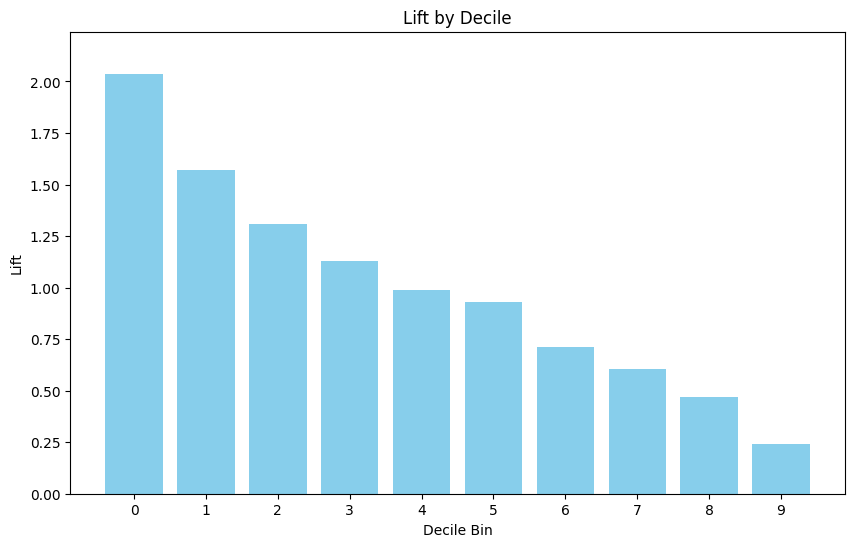


Gini Score: 0.3887
---------------
BalancedRandomForestClassifier Results:
Confusion Matrix:
[[24766    25]
 [ 8328    63]]

Classification Report:
              precision    recall  f1-score   support

       False       0.75      1.00      0.86     24791
        True       0.72      0.01      0.01      8391

    accuracy                           0.75     33182
   macro avg       0.73      0.50      0.44     33182
weighted avg       0.74      0.75      0.64     33182


Accuracy Score:
0.7482671327828341
---------------


In [9]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

# Initialize and train the BalancedRandomForestClassifier with Fine-tuned hyperparameters 
model_BRFC = BalancedRandomForestClassifier(
    random_state=42,
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features='sqrt',
    max_depth=100,
    bootstrap=True,
    sampling_strategy={False: 5000, True: 1000}, 
    replacement=True  
)
model_BRFC.fit(X_train, y_train)

def compute_lift(y_true, y_scores, n_bins=10):
    """
    Compute lift for each quantile (bin) of predicted probabilities.
    
    Parameters:
        y_true (array-like): True binary labels.
        y_scores (array-like): Predicted probabilities for the positive class.
        n_bins (int): Number of bins (quantiles) to divide the data into.
        
    Returns:
        lift_df (pd.DataFrame): DataFrame containing the count, positive rate, and lift for each bin.
    """
    # Create DataFrame with true labels and predicted scores
    df = pd.DataFrame({'y_true': y_true, 'y_scores': y_scores})
    # Sort descending by predicted probability
    df = df.sort_values('y_scores', ascending=False).reset_index(drop=True)
    # Create bins based on the index quantiles
    df['bin'] = pd.qcut(df.index, q=n_bins, labels=False)
    
    # Overall positive rate in the dataset
    overall_rate = df['y_true'].mean()
    
    # Aggregate data by bin: count and average positive rate per bin
    lift_df = df.groupby('bin').agg(
        count=('y_true', 'count'),
        positive_rate=('y_true', 'mean')
    ).reset_index()
    # Compute lift as the ratio of bin positive rate to overall positive rate
    lift_df['lift'] = lift_df['positive_rate'] / overall_rate
    
    return lift_df

def compute_gini(y_true, y_scores):
    """
    Compute the Gini coefficient using the ROC-AUC score.
    
    Parameters:
        y_true (array-like): True binary labels.
        y_scores (array-like): Predicted probabilities for the positive class.
    
    Returns:
        gini (float): The Gini coefficient.
    """
    auc = roc_auc_score(y_true, y_scores)
    return 2 * auc - 1

y_pred_proba = model_BRFC.predict_proba(X_test)[:, 1]

# Compute lift by deciles
lift_df = compute_lift(y_test, y_pred_proba, n_bins=10)

# Plot the lift by decile using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(lift_df['bin'], lift_df['lift'], color='skyblue')
plt.xlabel("Decile Bin")
plt.ylabel("Lift")
plt.title("Lift by Decile")
plt.xticks(lift_df['bin'])
plt.ylim(0, max(lift_df['lift'])*1.1)  # Extend y-axis slightly for better visual appearance
plt.show()

# Compute Gini coefficient
gini_score = compute_gini(y_test, y_pred_proba)
print(f"\nGini Score: {gini_score:.4f}")

# Make predictions on the test set with BalancedRandomForestClassifier
y_pred = model_BRFC.predict(X_test)
# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
acc_score = accuracy_score(y_test, y_pred)
print("---------------")
print("BalancedRandomForestClassifier Results:")
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
print("\nAccuracy Score:")
print(acc_score)
print("---------------")

[LightGBM] [Info] Number of positive: 19386, number of negative: 58036
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1712
[LightGBM] [Info] Number of data points in the train set: 77422, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250394 -> initscore=-1.096512
[LightGBM] [Info] Start training from score -1.096512


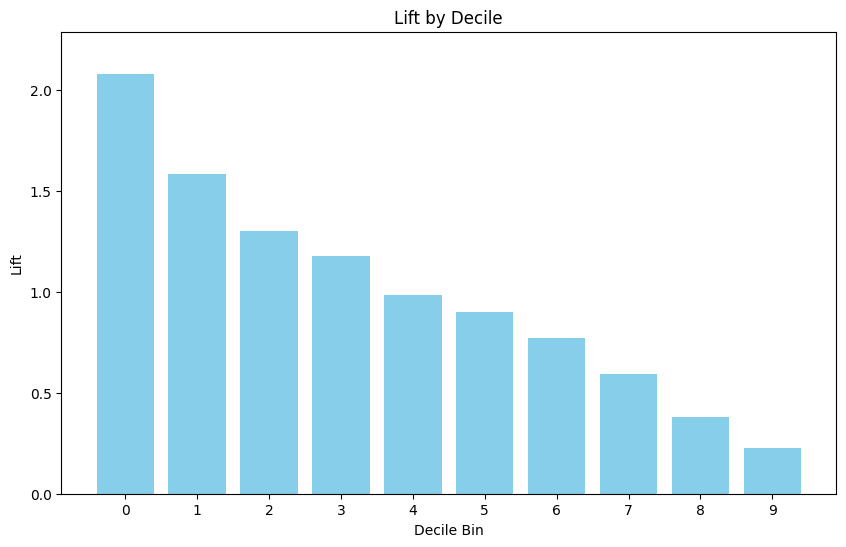


Gini Score: 0.4058
---------------
LightGBM Results:
Confusion Matrix:
 [[23885   906]
 [ 7288  1103]]
Classification Report:
               precision    recall  f1-score   support

       False       0.77      0.96      0.85     24791
        True       0.55      0.13      0.21      8391

    accuracy                           0.75     33182
   macro avg       0.66      0.55      0.53     33182
weighted avg       0.71      0.75      0.69     33182

Accuracy: 0.7530588873485625
---------------


In [10]:
import lightgbm as lgb

# Initialize the LightGBM classifier with sample hyperparameters
model_LGBM = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    random_state=42
)

# Train the model
model_LGBM.fit(X_train, y_train)

y_pred_proba = model_LGBM.predict_proba(X_test)[:, 1]

# Compute lift by deciles
lift_df = compute_lift(y_test, y_pred_proba, n_bins=10)

# Plot the lift by decile using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(lift_df['bin'], lift_df['lift'], color='skyblue')
plt.xlabel("Decile Bin")
plt.ylabel("Lift")
plt.title("Lift by Decile")
plt.xticks(lift_df['bin'])
plt.ylim(0, max(lift_df['lift'])*1.1)  # Extend y-axis slightly for better visual appearance
plt.show()

# Compute Gini coefficient
gini_score = compute_gini(y_test, y_pred_proba)
print(f"\nGini Score: {gini_score:.4f}")

# Make predictions on the test set
y_pred = model_LGBM.predict(X_test)

# Evaluate the model
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print("---------------")
print("LightGBM Results:")
print("Confusion Matrix:\n", cm) 
print("Classification Report:\n", cr)
print("Accuracy:", acc)
print("---------------")



In [11]:
import pickle

# Save the model
model_path_BRFC = "customer_churn_prediction_model_brfc.pkl"
model_path_LGBM = "customer_churn_prediction_model_lgbm.pkl"

with open(model_path_BRFC, 'wb') as model_file:
    pickle.dump((model_BRFC, X_train.columns.tolist()), model_file)
print(f"Customer Churn Prediction Random Forest classifier Model Saved to {model_path_BRFC}")

with open(model_path_LGBM, 'wb') as model_file:
    pickle.dump((model_LGBM, X_train.columns.tolist()), model_file)
print(f"Customer Churn Prediction LightGBM classifier Model Saved to {model_path_LGBM}")

Customer Churn Prediction Random Forest classifier Model Saved to customer_churn_prediction_model_brfc.pkl
Customer Churn Prediction LightGBM classifier Model Saved to customer_churn_prediction_model_lgbm.pkl


In [12]:
# Create File
FILE_ON_DISK = 'customer_churn_prediction_model_brfc.pkl'
bucket_name = 'openshift'

# Upload a File 
file_path = FILE_ON_DISK
object_name = 'models/customer_churn_prediction_model_brfc.pkl'

try:
    client.fput_object(AWS_S3_BUCKET, object_name, file_path)
    print(f"'{object_name}' is successfully uploaded as object to bucket '{bucket_name}'.")
except S3Error as e:
    print("Error occurred: ", e)

'models/customer_churn_prediction_model_brfc.pkl' is successfully uploaded as object to bucket 'openshift'.


In [13]:
# Create File
FILE_ON_DISK = 'customer_churn_prediction_model_lgbm.pkl'
bucket_name = 'openshift'

# Upload a File 
file_path = FILE_ON_DISK
object_name = 'models/customer_churn_prediction_model_lgbm.pkl'

try:
    client.fput_object(AWS_S3_BUCKET, object_name, file_path)
    print(f"'{object_name}' is successfully uploaded as object to bucket '{bucket_name}'.")
except S3Error as e:
    print("Error occurred: ", e)

'models/customer_churn_prediction_model_lgbm.pkl' is successfully uploaded as object to bucket 'openshift'.
